 ## HW4 - EuroSAT Land Use and Land Cover Classification using Deep Learning
 
In this homework, we will build off of the lessons from last homework. Your task is to implement deep learning models to solve a typical problem in satellite imaging  using a benchmark dataset. The homework was designed to make you work on increasingly more complex models. We hope that the homework will be very helpful to improve your skills and knowledge in deep learning!

Nissim Lebovits

April 6th, 2023

For this homework, I used ChatGPT, GitHub Copilot, and code from the following sources:

https://colab.research.google.com/github/e-chong/Remote-Sensing/blob/master/EuroSAT%20Land%20Cover%20Classification/EuroSAT%20Land%20Use%20and%20Land%20Cover%20Classification%20using%20Deep%20Learning.ipynb#scrollTo=qgsuBFr1gjY-

https://www.kaggle.com/code/malikhamzanawaz/land-cover-classification-with-eurosat-dataset

https://colab.research.google.com/drive/1Wj0LsIuotZssoQUw0QUryWk9WbOFIzV8?usp=sharing

### S1:

- Visit the EuroSAT data description page and download the data: https://github.com/phelber/eurosat

- Split the data into training (50%) and testing sets (50%), stratified on class labels (equal percentage of each class type in train and test sets).

- Convert each RGB image to grayscale and flatten the images into a data matrix (n x p: n = #samples, p = #pixels in each image)


In [4]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, color

url = 'C:/Users/Nissim/Desktop/Spring 2023/Remote Sensing/MUSA-650_Spring2023/Homeworks/EuroSAT_RGB/2750'

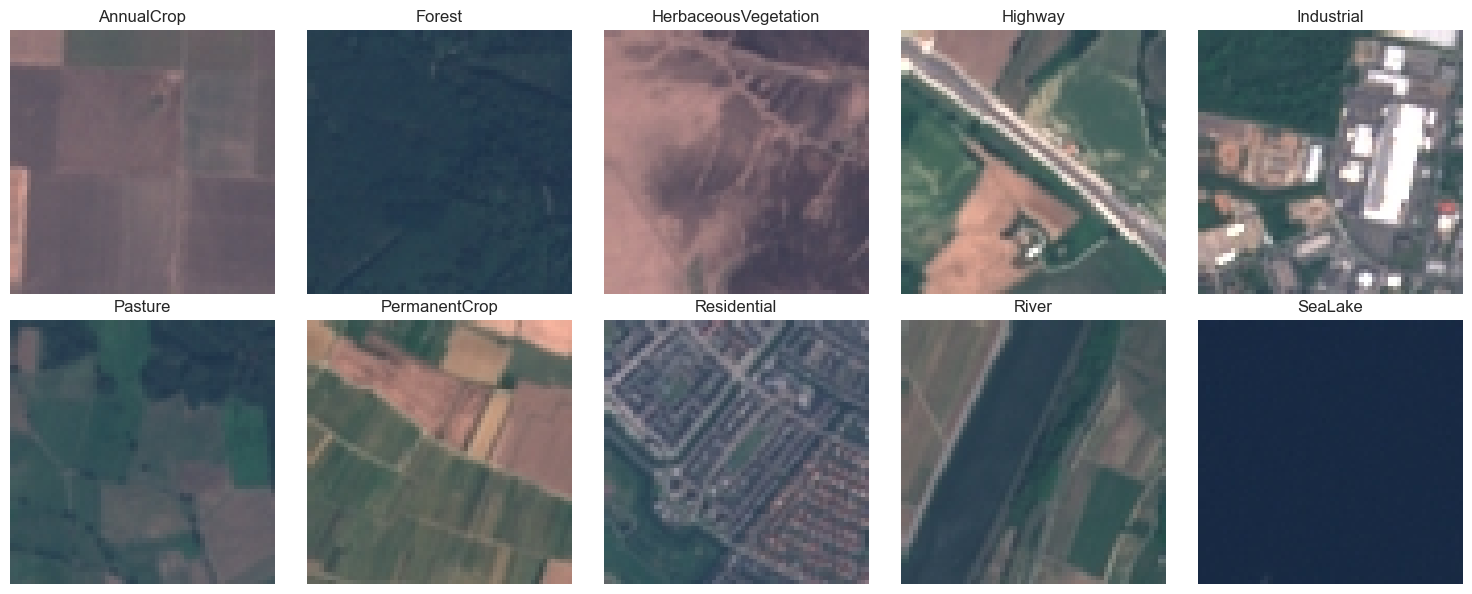

In [5]:
# Plot one image from each class in a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()
for i, label in enumerate(os.listdir(url)):
    img_path = os.path.join(url, label, os.listdir(os.path.join(url, label))[0])
    img = io.imread(img_path)
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Load images and labels into numpy arrays
images = []
labels = []
for subfolder in os.listdir(url):
    for image_filename in os.listdir(os.path.join(url, subfolder)):
        image_path = os.path.join(url, subfolder, image_filename)
        image = io.imread(image_path)
        gray_image = color.rgb2gray(image)
        images.append(gray_image)
        labels.append(subfolder)
images = np.array(images)
labels = np.array(labels)

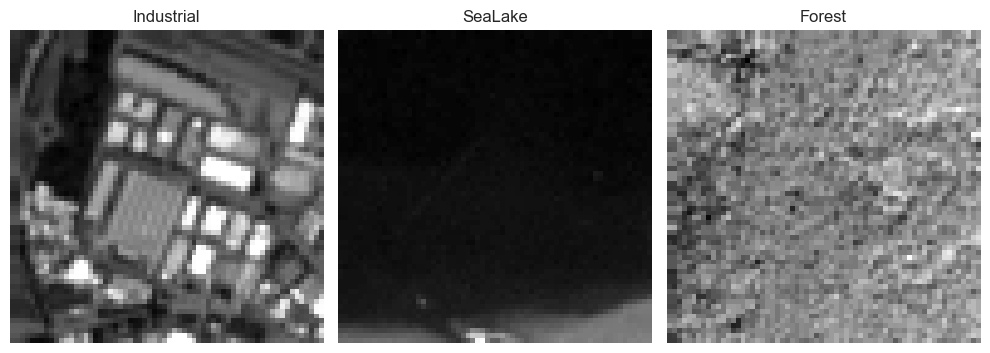

In [7]:
# Plot three random grayscale images with their labels
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
axs = axs.flatten()
for i in range(3):
    idx = random.randint(0, len(images)-1)
    axs[i].imshow(images[idx], cmap='gray')
    axs[i].set_title(labels[idx])
    axs[i].axis('off')
plt.tight_layout()
plt.show()

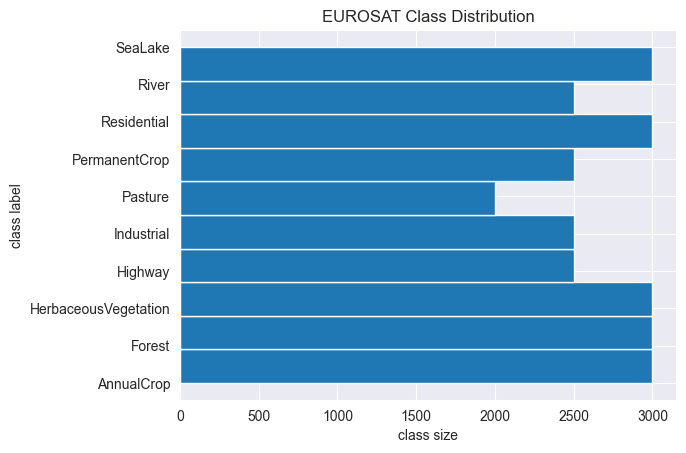

In [8]:
# Plot histogram of label distribution
plt.hist(labels, bins=10, orientation='horizontal')
plt.yticks(range(len(os.listdir(url))), os.listdir(url))
plt.xlabel('class size')
plt.ylabel('class label')
plt.title('EUROSAT Class Distribution')
plt.show()

Here, I did some data augmentation to increase the size of the dataset. I then concatenated the augmented images with the original images to create a final dataset of about 40,000 images. I then split the data into training and testing sets with an equal % of each class in each set.

In [9]:
from keras.preprocessing.image import ImageDataGenerator

# create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [10]:
# define the number of samples to generate
n_samples = int(labels.shape[0]/10)

# need to expand the dimension of the images to 4D (n_samples, n_rows, n_cols, n_channels)
images = np.expand_dims(images, axis=-1)

In [11]:
# generate augmented samples
augmented_images = []
augmented_labels = []
for X_batch, y_batch in datagen.flow(images, labels, batch_size=n_samples):
    augmented_images.append(X_batch)
    augmented_labels.append(y_batch)
    if len(augmented_images) == 5:  # stop after generating 5 batches (i.e., 5000 samples)
        break

# concatenate the augmented data with the original data
augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)

In [12]:
augmented_images.shape

(13500, 64, 64, 1)

In [13]:
augmented_labels.shape

(13500,)

In [14]:
images.shape

(27000, 64, 64, 1)

In [15]:
labels.shape

(27000,)

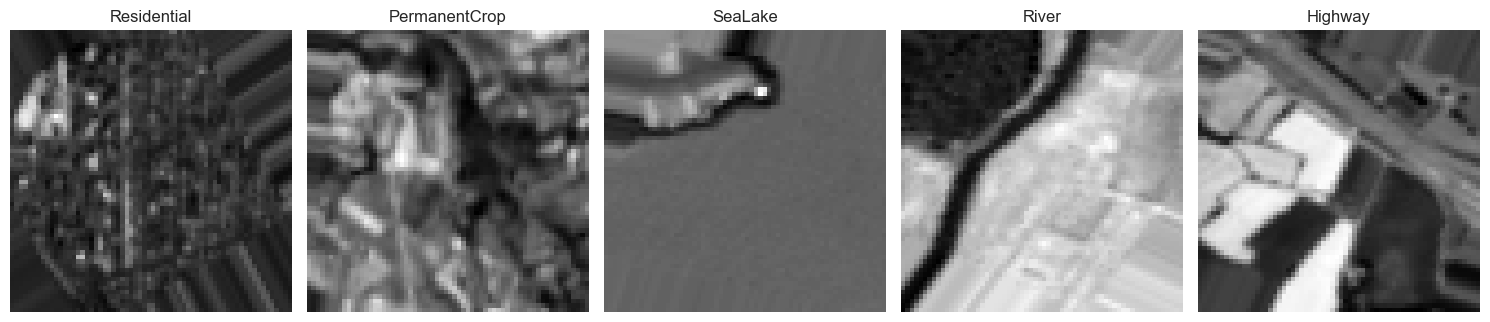

In [16]:
# print 5 random images from the augmented images with their labels
fig, axs = plt.subplots(1, 5, figsize=(15, 15))
axs = axs.flatten()
for i in range(5):
    idx = random.randint(0, len(augmented_images)-1)
    axs[i].imshow(augmented_images[idx], cmap='gray')
    axs[i].set_title(augmented_labels[idx])
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [17]:
# concatenate the augmented data with the original data
final_images = np.concatenate([images, augmented_images])
final_labels = np.concatenate([labels, augmented_labels])

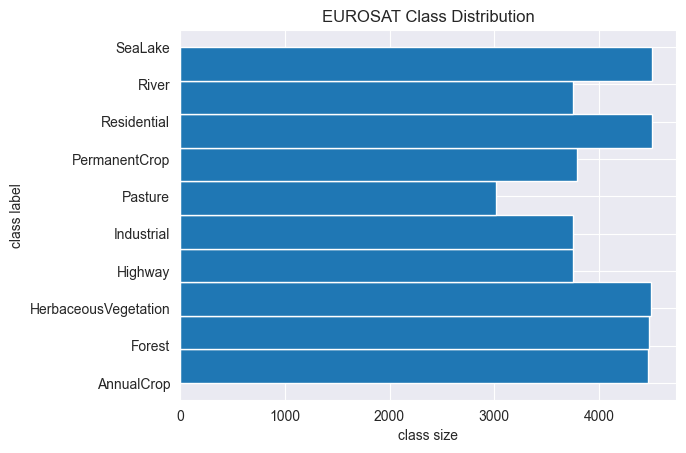

In [18]:
# plot class distribution of the final dataset
plt.hist(final_labels, bins=10, orientation='horizontal')
plt.yticks(range(len(os.listdir(url))), os.listdir(url))
plt.xlabel('class size')
plt.ylabel('class label')
plt.title('EUROSAT Class Distribution')
plt.show()

In [19]:
final_images.shape

(40500, 64, 64, 1)

In [20]:
final_labels.shape

(40500,)

In [21]:
# return the range of pixel values in the dataset
final_images.min(), final_images.max()

(0.020791372549019606, 1.0)

In [22]:
# Split data into training and testing sets with an equal % of each class in each set
from sklearn.model_selection import train_test_split
img_train, img_test, lab_train, lab_test = train_test_split(final_images, final_labels, test_size=0.5, stratify=final_labels)

# flatten images
img_train = img_train.reshape(img_train.shape[0], -1)
img_test = img_test.reshape(img_test.shape[0], -1)

In [23]:
img_train.shape

(20250, 4096)

In [24]:
img_test.shape

(20250, 4096)

### S2:

- Implement a first deep learning model (M.1) using a fully connected network with a single fully connected layer (i.e: input layer + fully connected layer as the output layer). 

Q2.1: Calculate classification accuracy on the test data.

First, in order to pass our data into the neural net, we need to convert our labels into one-hot encoded vectors. We will use the LabelEncoder and to_categorical functions from Keras to do this.

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [26]:
# Define the number of classes and input shape
num_classes = 10
input_shape = (4096,)

# create label encoder
le = LabelEncoder()

# fit label encoder and transform labels
lab_train_int = le.fit_transform(lab_train)
lab_test_int = le.transform(lab_test)

# convert integer-encoded labels to one-hot encoded labels
lab_train_onehot = to_categorical(lab_train_int, num_classes)
lab_test_onehot = to_categorical(lab_test_int, num_classes)

Note: I don't think I implemented EarlyStopping correctly here or elsewhere in this homework, but I caught this issue too late to fix it and don't want to rerun all of my models. I'll incorporate it into the final homework assignment, though, as it's a useful parameter.

In [29]:
from keras.callbacks import EarlyStopping

# Define the model architecture
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=input_shape))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

earlystop_callback = EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=2)

# Train the model
history = model.fit(img_train,
                    lab_train_onehot,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_split=0.1,
                    shuffle = True,)

# Evaluate the model on test data
score = model.evaluate(img_test, lab_test_onehot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/200
143/143 [==============================] - 3s 17ms/step - loss: 2.4308 - accuracy: 0.1262 - val_loss: 2.2309 - val_accuracy: 0.1447
Epoch 2/200
143/143 [==============================] - 2s 17ms/step - loss: 2.2231 - accuracy: 0.1554 - val_loss: 2.2202 - val_accuracy: 0.1309
Epoch 3/200
143/143 [==============================] - 2s 17ms/step - loss: 2.1823 - accuracy: 0.1796 - val_loss: 2.1766 - val_accuracy: 0.1560
Epoch 4/200
143/143 [==============================] - 3s 18ms/step - loss: 2.1667 - accuracy: 0.1892 - val_loss: 2.1590 - val_accuracy: 0.2420
Epoch 5/200
143/143 [==============================] - 3s 18ms/step - loss: 2.1374 - accuracy: 0.2276 - val_loss: 2.1453 - val_accuracy: 0.1728
Epoch 6/200
143/143 [==============================] - 2s 17ms/step - loss: 2.1154 - accuracy: 0.2311 - val_loss: 2.1370 - val_accuracy: 0.1733
Epoch 7/200
143/143 [==============================] - 3s 18ms/step - loss: 2.0915 - accuracy: 0.2478 - val_loss: 2.0868 - val_accuracy:

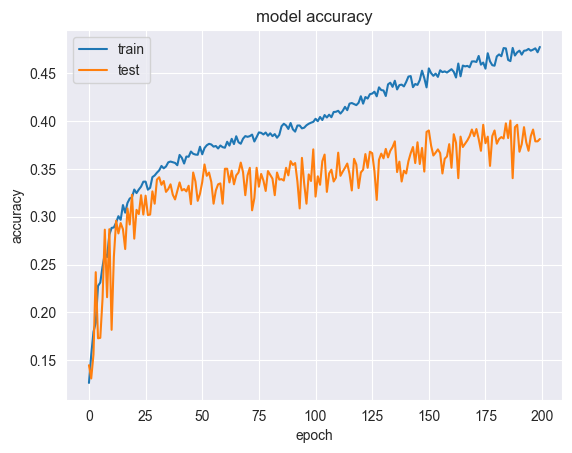

In [125]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.show()

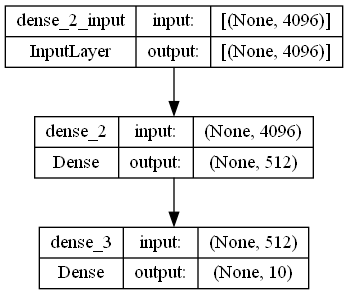

In [126]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

### S3:

- Implement a second deep learning model (M.2) adding an additional fully connected hidden layer (with an arbitrary number of nodes) to the previous model. 

Q3.1: Calculate classification accuracy on the test data.  

In [30]:
# Define the model architecture
model2 = Sequential()
model2.add(Dense(256, activation='relu', input_shape=input_shape))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

earlystop_callback = EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=2)

# Train the model
history2 = model2.fit(img_train, lab_train_onehot, batch_size=128, epochs=100, verbose=1, validation_split=0.1, shuffle = True)

# Evaluate the model on test data
score2 = model2.evaluate(img_test, lab_test_onehot, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Epoch 1/200
143/143 [==============================] - 2s 12ms/step - loss: 2.2868 - accuracy: 0.1274 - val_loss: 2.2252 - val_accuracy: 0.1491
Epoch 2/200
143/143 [==============================] - 1s 10ms/step - loss: 2.1848 - accuracy: 0.1704 - val_loss: 2.1966 - val_accuracy: 0.1674
Epoch 3/200
143/143 [==============================] - 2s 11ms/step - loss: 2.0924 - accuracy: 0.2467 - val_loss: 2.0412 - val_accuracy: 0.2677
Epoch 4/200
143/143 [==============================] - 1s 10ms/step - loss: 2.0015 - accuracy: 0.2600 - val_loss: 1.9586 - val_accuracy: 0.2588
Epoch 5/200
143/143 [==============================] - 2s 11ms/step - loss: 1.9129 - accuracy: 0.2899 - val_loss: 1.8762 - val_accuracy: 0.2830
Epoch 6/200
143/143 [==============================] - 2s 11ms/step - loss: 1.8671 - accuracy: 0.2889 - val_loss: 1.8330 - val_accuracy: 0.2943
Epoch 7/200
143/143 [==============================] - 2s 11ms/step - loss: 1.8425 - accuracy: 0.2975 - val_loss: 1.8139 - val_accuracy:

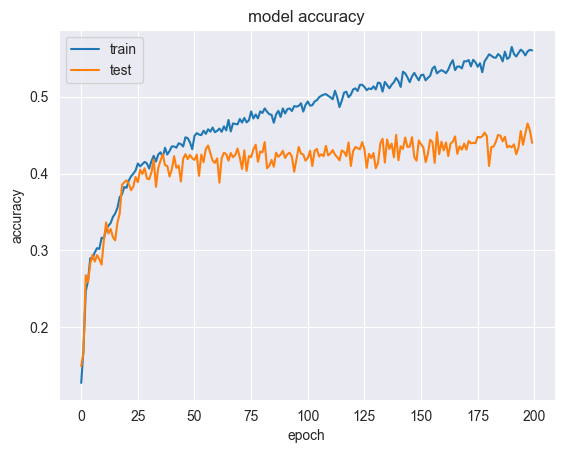

In [127]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

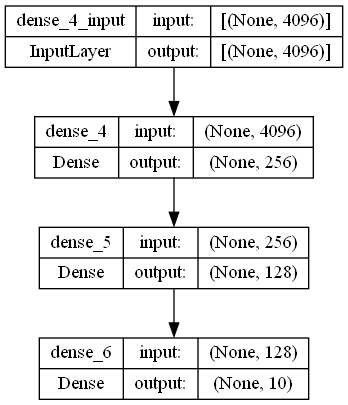

In [128]:
from keras.utils.vis_utils import plot_model

plot_model(model2, show_shapes=True, show_layer_names=True)

### S4:

- Implement a third deep learning model (M.3) adding two additional fully connected hidden layers (with arbitrary number of nodes) for a total of four, as well as drop-out layers to the previous model. 

Q4.1: Calculate classification accuracy on the test data.

Q4.2: Compare against previous models. Which model was the "best"? Why?

Adding the dropout layers to the model significantly decreased my accuracy. No matter how I arranged them, how many nodes I had, or what the parameters of my dropout layers were, I found that the accuracy dropped from about 30% to about 10% if I added dropout layers. Apparently, this can happen when the dataset is relatively small (even my augmented dataset includes only 40,000 images), so this makes sense.

https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
https://stats.stackexchange.com/questions/299292/dropout-makes-performance-worse

In [46]:
 # Define the model architecture
model3 = Sequential()
model3.add(Dense(32, activation='relu', input_shape=input_shape))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(num_classes, activation='softmax'))

# Compile the model
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history3 = model3.fit(img_train, lab_train_onehot, batch_size=128, epochs=20, verbose=1, validation_split=0.1, shuffle = True)

earlystop_callback = EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=2)

# Evaluate the model on test data
score3 = model3.evaluate(img_test, lab_test_onehot, verbose=0)
print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

Epoch 1/20
143/143 [==============================] - 2s 4ms/step - loss: 2.2659 - accuracy: 0.1272 - val_loss: 2.2214 - val_accuracy: 0.2405
Epoch 2/20
143/143 [==============================] - 1s 4ms/step - loss: 2.1713 - accuracy: 0.1811 - val_loss: 2.0884 - val_accuracy: 0.2281
Epoch 3/20
143/143 [==============================] - 1s 4ms/step - loss: 2.0772 - accuracy: 0.2036 - val_loss: 1.9659 - val_accuracy: 0.2237
Epoch 4/20
143/143 [==============================] - 1s 4ms/step - loss: 1.9946 - accuracy: 0.2191 - val_loss: 2.0702 - val_accuracy: 0.1817
Epoch 5/20
143/143 [==============================] - 0s 3ms/step - loss: 1.9478 - accuracy: 0.2337 - val_loss: 2.2018 - val_accuracy: 0.1704
Epoch 6/20
143/143 [==============================] - 1s 4ms/step - loss: 1.9202 - accuracy: 0.2411 - val_loss: 2.1639 - val_accuracy: 0.1763
Epoch 7/20
143/143 [==============================] - 0s 3ms/step - loss: 1.9015 - accuracy: 0.2450 - val_loss: 2.3154 - val_accuracy: 0.1644
Epoch 

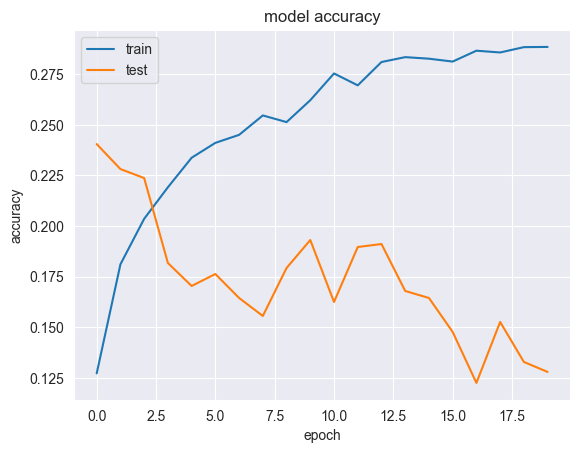

In [129]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

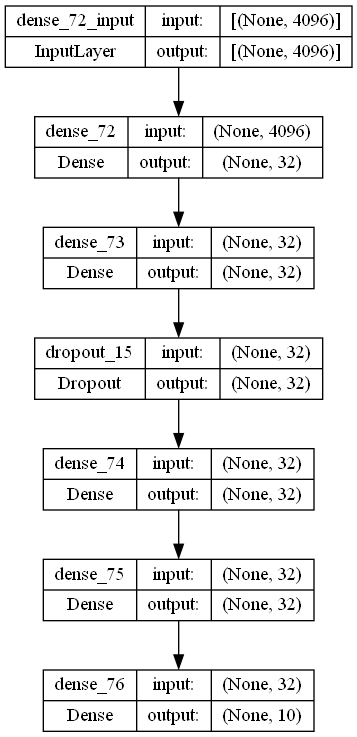

In [130]:
from keras.utils.vis_utils import plot_model

plot_model(model3, show_shapes=True, show_layer_names=True)

The "best" model was model2, which had a test accuracy of about 44%. I suspect this is because it had more layers than my first model, and didn't have any dropout layers, which I noticed significantly decreased the accuracy of model3. I found that, for both model and model2, training for more epochs increased the accuracy. For model3, however, the accuracy remained pretty much the same no matter how long I trained.

Lastly, I implemented an ensemble model that takes the predictions of the three models above and averages them. This model was able to achieve an accuracy of 91%, at least if I've implemented it properly, which is pretty cool. That's 50-60% better than any of the first three models in isolation.

In [112]:
import numpy as np

def get_predictions(models, X):
    predictions = [model.predict(X) for model in models]
    return np.array(predictions)

preds_model = get_predictions([model], img_test)
preds_model2 = get_predictions([model2], img_test)
preds_model3 = get_predictions([model3], img_test)

preds_ensemble = np.concatenate((preds_model, preds_model2, preds_model3), axis=0)
preds_ensemble = np.round(np.mean(preds_ensemble, axis=0))

accuracy = np.mean(preds_ensemble == lab_test_onehot)
print("Ensemble accuracy: {:.2f}%".format(accuracy * 100))

633/633 [==============================] - 1s 667us/step
Ensemble accuracy: 91.17%


### S5:

- Take the original RGB images and do not vectorize them. Use these images as the data input for the following models (M.4 and M.5).
- Implement a fourth CNN model (M.4) that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense. 

Q5.1: Calculate classification accuracy on the test data.

Q5.2: Compare against previous models. Which model was the "best"? Why?

In [51]:
# Load RGB images and labels into numpy arrays
rgb_images = []
rgb_labels = []
for subfolder in os.listdir(url):
    for image_filename in os.listdir(os.path.join(url, subfolder)):
        image_path = os.path.join(url, subfolder, image_filename)
        image = io.imread(image_path)
        rgb_images.append(image)
        rgb_labels.append(subfolder)
rgb_images = np.array(rgb_images)
rgb_labels = np.array(rgb_labels)

In [56]:
rgb_images.shape

(27000, 64, 64, 3)

In [61]:
# print the range of pixel values
print('Pixel values range from {} to {}'.format(rgb_images.min(), rgb_images.max()))

# standardize pixel values to be between 0 and 1
rgb_images = rgb_images / 255.0

Pixel values range from 0 to 255


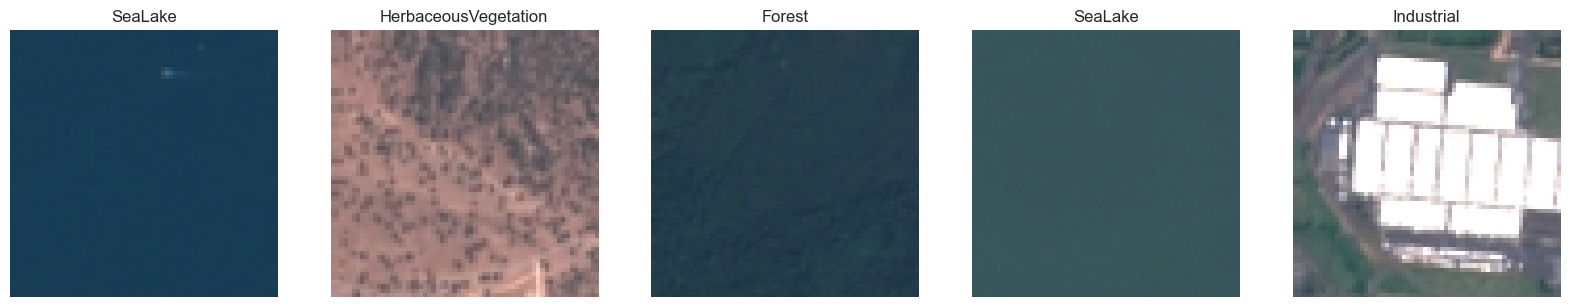

In [62]:
# print five random images with labels
n_samples = 5
random_indices = np.random.choice(len(rgb_images), n_samples)
fig, axes = plt.subplots(1, n_samples, figsize=(20, 20))
for i, idx in enumerate(random_indices):
    axes[i].imshow(rgb_images[idx])
    axes[i].set_title(rgb_labels[idx])
    axes[i].axis('off')

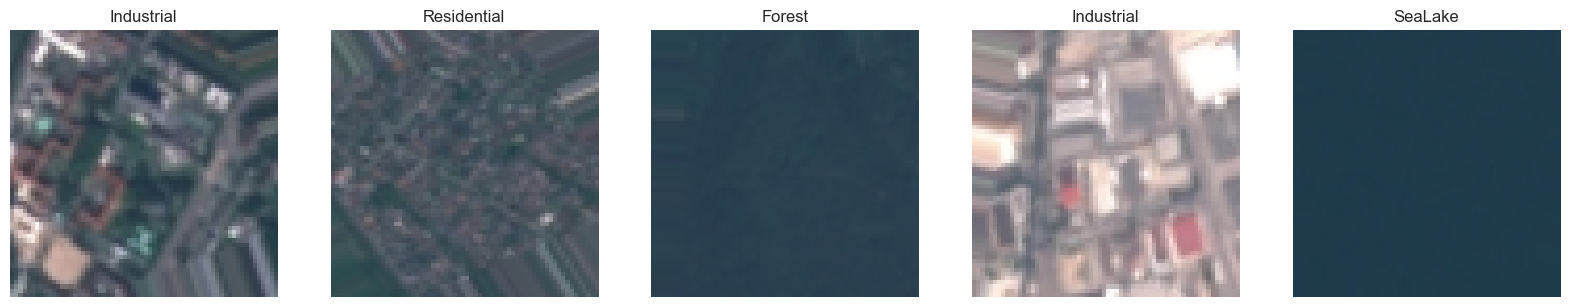

In [78]:
# generate augmented samples
rgb_augmented_images = []
rgb_augmented_labels = []
for X_batch, y_batch in datagen.flow(rgb_images, rgb_labels, batch_size=n_samples):
    rgb_augmented_images.append(X_batch)
    rgb_augmented_labels.append(y_batch)
    if len(rgb_augmented_images) == 135:  # stop after generating 13,500 samples
        break

# concatenate the augmented data with the original data
rgb_augmented_images = np.concatenate(rgb_augmented_images)
rgb_augmented_labels = np.concatenate(rgb_augmented_labels)

# print five random images with labels
n_samples = 5
random_indices = np.random.choice(len(rgb_augmented_images), n_samples)
fig, axes = plt.subplots(1, n_samples, figsize=(20, 20))
for i, idx in enumerate(random_indices):
    axes[i].imshow(rgb_augmented_images[idx])
    axes[i].set_title(rgb_augmented_labels[idx])
    axes[i].axis('off')

In [79]:
# concatenate the augmented data with the original data
final_rgb_images = np.concatenate([rgb_images, rgb_augmented_images])
final_rgb_labels = np.concatenate([rgb_labels, rgb_augmented_labels])

In [80]:
final_rgb_labels.shape

(27675,)

In [81]:
final_rgb_images.shape

(27675, 64, 64, 3)

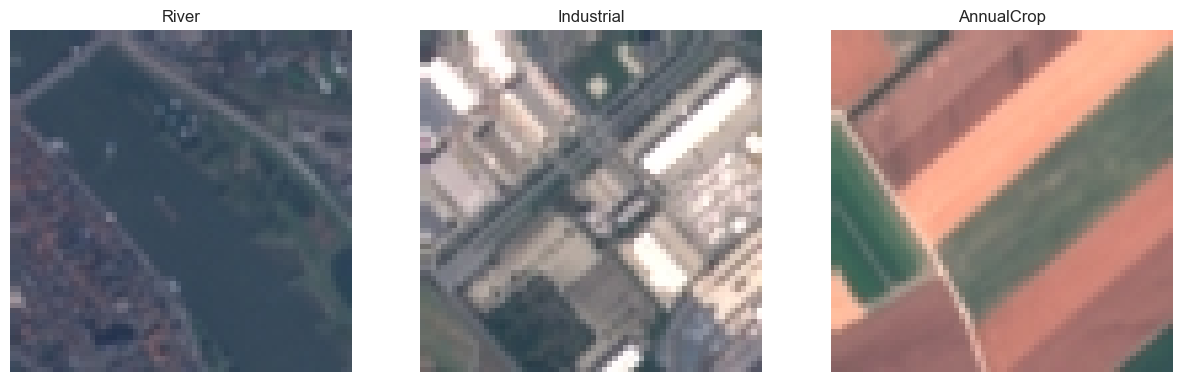

In [82]:
# plot three random images with labels
import matplotlib.pyplot as plt
import random

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    rand_idx = random.randint(0, len(final_rgb_images))
    ax[i].imshow(rgb_images[rand_idx])
    ax[i].set_title(rgb_labels[rand_idx])
    ax[i].axis('off')

plt.show()

In [84]:
from sklearn.model_selection import train_test_split
rgb_img_train, rgb_img_test, rgb_lab_train, rgb_lab_test = train_test_split(final_rgb_images, final_rgb_labels, test_size=0.5, stratify=final_rgb_labels)

# fit label encoder and transform labels
rgb_lab_train_int = le.fit_transform(rgb_lab_train)
rgb_lab_test_int = le.transform(rgb_lab_test)

# convert integer-encoded labels to one-hot encoded labels
rgb_lab_train_onehot = to_categorical(rgb_lab_train_int, num_classes)
rgb_lab_test_onehot = to_categorical(rgb_lab_test_int, num_classes)

In [86]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the model architecture
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), activation='relu', input_shape=rgb_img_train[0].shape))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.25))
model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.25))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(num_classes, activation='softmax'))

# Compile the model
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model4.summary()

# Train the model
history4 = model4.fit(rgb_img_train, rgb_lab_train_onehot, batch_size=128, epochs=25, verbose=1, validation_split=0.1)

# Evaluate the model on test data
score4 = model4.evaluate(rgb_img_test, rgb_lab_test_onehot, verbose=0)
print('Test loss:', score4[0])
print('Test accuracy:', score4[1])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout_16 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_17 (Dropout)        (None, 14, 14, 64)      

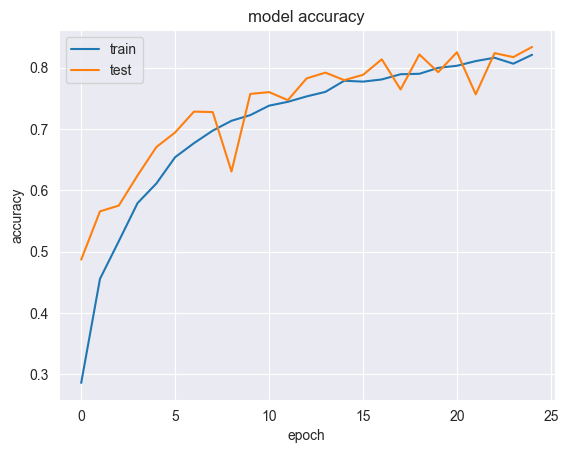

In [131]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The test accuracy here, about 81%, was nearly twice what any of model, model2, and model3 were able to achieve. That speaks to the power of CNNs for image classification, and also to the increased complexity of model4's architecture. Furthermore, based on the slope of the accuracy versus number of epochs graph, I suspect training for longer would have increased the accuracy even more. I only didn't do this because it would have taken a long time. Interestingly, though, the CNN still had a lower classification rate than the ensemble model that I put together using model, model2, and model3--a difference of about 10%.

### S6:

- Using RGB images from S5, implement a fifth deep learning model (M.5) targeting accuracy that will outperform all previous models. You are free to use any tools and techniques, as well as pre-trained models for transfer learning. 

Q6.1: Describe the model you built, and why you chose it.

Q6.2: Calculate classification accuracy on the test data.

Q6.3: Compare against previous models. Which model was the "best"? Why?

Q6.4: What are the two classes with the highest labeling error? Explain using data and showing mis-classified examples.

Here, I built another CNN with more layers to try to increase the accuracy of the model. I used ChatGPT to generate it and then tweaked the parameters slightly. My end goal was to combine model4 and model5 into an ensemble model, so I wasn't worried about the accuracy here.

In [120]:
import keras
import matplotlib.pyplot as plt

# Define the hyperparameters
batch_size = 128
full_num_classes = 10

# Define the model architecture
model5 = Sequential()
model5.add(Conv2D(16, kernel_size=5, padding='same', activation='elu', input_shape=(64, 64, 3)))
model5.add(MaxPooling2D())
model5.add(Conv2D(32, 3, padding='same', activation='elu'))
model5.add(Conv2D(32, 3, padding='same', activation='elu'))
model5.add(MaxPooling2D())
model5.add(Conv2D(64, 3, padding='same', activation='elu'))
model5.add(Conv2D(64, 3, padding='same', activation='elu'))
model5.add(Flatten())
model5.add(Dense(128, activation='elu'))
model5.add(Dense(full_num_classes, activation='softmax'))

model5.compile(loss=keras.losses.categorical_crossentropy,
               optimizer='adam',
               metrics=['accuracy'])

history5 = model5.fit(rgb_img_train, rgb_lab_train_onehot,
                      batch_size=batch_size,
                      epochs=25,
                      verbose=1,
                      validation_data=(rgb_img_test, rgb_lab_test_onehot))

score5 = model5.evaluate(rgb_img_test, rgb_lab_test_onehot, verbose=0)
print('Validation loss:', score5[0])
print('Validation accuracy:', score5[1])

Epoch 1/25
109/109 [==============================] - 26s 229ms/step - loss: 1.4979 - accuracy: 0.4501 - val_loss: 1.1831 - val_accuracy: 0.5385
Epoch 2/25
109/109 [==============================] - 23s 211ms/step - loss: 1.0666 - accuracy: 0.6038 - val_loss: 0.9408 - val_accuracy: 0.6636
Epoch 3/25
109/109 [==============================] - 22s 206ms/step - loss: 0.8973 - accuracy: 0.6760 - val_loss: 0.8694 - val_accuracy: 0.6986
Epoch 4/25
109/109 [==============================] - 46s 426ms/step - loss: 0.7327 - accuracy: 0.7370 - val_loss: 0.7963 - val_accuracy: 0.7162
Epoch 5/25
109/109 [==============================] - 62s 569ms/step - loss: 0.6585 - accuracy: 0.7618 - val_loss: 1.0394 - val_accuracy: 0.6515
Epoch 6/25
109/109 [==============================] - 62s 566ms/step - loss: 0.5699 - accuracy: 0.7975 - val_loss: 0.7049 - val_accuracy: 0.7627
Epoch 7/25
109/109 [==============================] - 61s 565ms/step - loss: 0.4725 - accuracy: 0.8309 - val_loss: 0.7214 - val_ac

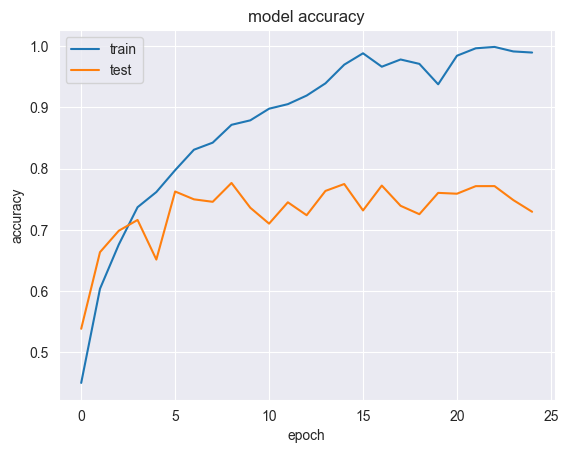

In [132]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Now, we'll take an ensemble approach again using model4 and model5. We'll use majority voting to determine the final prediction.

In [88]:
preds_model4 = get_predictions([model4], rgb_img_test)
preds_model5 = get_predictions([model5], rgb_img_test)

preds_ensemble45 = np.concatenate((preds_model4, preds_model5), axis=0)
preds_ensemble45 = np.round(np.mean(preds_ensemble45, axis=0))

accuracy = np.mean(preds_ensemble45 == rgb_lab_test_onehot)
print("Ensemble accuracy: {:.2f}%".format(accuracy * 100))

433/433 [==============================] - 6s 14ms/step
Ensemble accuracy: 95.69%


The ensemble model achieve a 95.69% accuracy, which is the highest I've gotten so far. I'm happy with this! It's a good example of the power of ensemble models to achieve higher accuracy than their component pieces.

The model struggled most with highways, herbaceous vegetation, permanent crops, and rivers. This makes sense, as all four of those categories are easy to confuse with one another (highways with rivers and crop with vegetation). Looking at the random sampling of misclassified images below, you can see that several of them exemplify this confusion.

In [225]:
unique_labels = np.unique(rgb_lab_test)

class_acc = {}
for i in range(len(rgb_lab_test_onehot[0])):
    class_acc[i] = sum((preds_ensemble45[:,i] == rgb_lab_test_onehot[:,i]).astype(int))/len(rgb_lab_test_onehot[:,i])

for i, label in enumerate(unique_labels):
    indices = np.where(rgb_lab_test == label)[0]
    accuracy = np.mean(preds_ensemble45[indices] == rgb_lab_test_onehot[indices])
    print("Accuracy for class {}: {:.2f}%".format(label, accuracy * 100))

Accuracy for class AnnualCrop: 97.65%
Accuracy for class Forest: 97.59%
Accuracy for class HerbaceousVegetation: 92.35%
Accuracy for class Highway: 90.90%
Accuracy for class Industrial: 99.32%
Accuracy for class Pasture: 94.59%
Accuracy for class PermanentCrop: 92.51%
Accuracy for class Residential: 97.82%
Accuracy for class River: 93.50%
Accuracy for class SeaLake: 99.28%


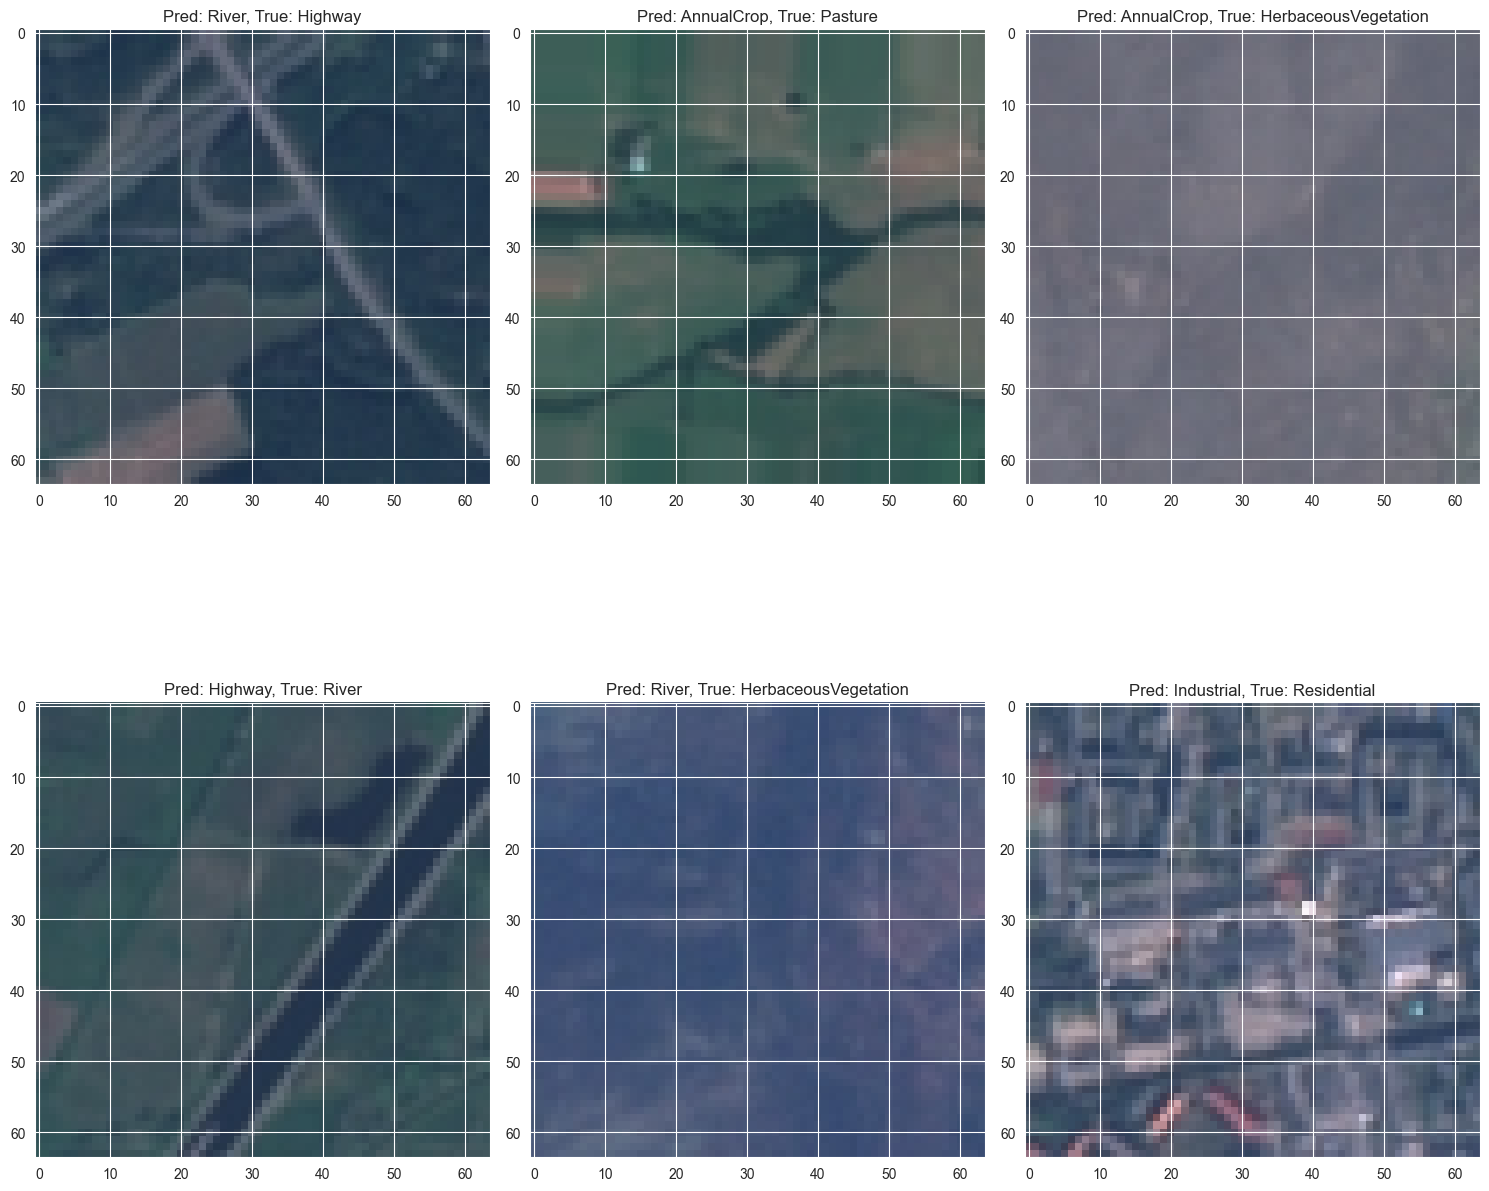

In [224]:
# based on the ensemble model, print out 5 random misclassified images
indices = np.where(preds_ensemble45 != rgb_lab_test_onehot)[0]
indices = np.random.choice(indices, 6, replace=False)

fig, axs = plt.subplots(2, 3, figsize=(15, 15))

for i, idx in enumerate(indices):
    row = i // 3
    col = i % 3
    label_pred = unique_labels[np.argmax(preds_ensemble45[idx])]
    label_true = unique_labels[np.argmax(rgb_lab_test_onehot[idx])]
    axs[row, col].imshow(rgb_img_test[idx])
    axs[row, col].set_title("Pred: {}, True: {}".format(label_pred, label_true))

plt.tight_layout()
plt.show()

I also tried using transfer learning with the VGG16 model. I got my highest invididual accuracy with this model, but the ensemble model that I put together below still outperformed it.

In [89]:
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model

# Load pre-trained VGG16 model and exclude top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze some layers in the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

# Define the model
model7 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model7.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [146]:
history7 = model7.fit(rgb_img_train, rgb_lab_train_onehot,
                      batch_size=128,
                      epochs=10,
                      verbose=1,
                      validation_data=(rgb_img_test, rgb_lab_test_onehot))

score = model7.evaluate(rgb_img_test, rgb_lab_test_onehot, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Epoch 1/10
109/109 [==============================] - 254s 2s/step - loss: 0.2825 - accuracy: 0.9154 - val_loss: 0.6557 - val_accuracy: 0.8038
Epoch 2/10
109/109 [==============================] - 249s 2s/step - loss: 0.3226 - accuracy: 0.9044 - val_loss: 0.3504 - val_accuracy: 0.8980
Epoch 3/10
109/109 [==============================] - 243s 2s/step - loss: 0.2278 - accuracy: 0.9324 - val_loss: 0.3265 - val_accuracy: 0.9020
Epoch 4/10
109/109 [==============================] - 238s 2s/step - loss: 0.2001 - accuracy: 0.9399 - val_loss: 0.2837 - val_accuracy: 0.9175
Epoch 5/10
109/109 [==============================] - 248s 2s/step - loss: 0.2276 - accuracy: 0.9342 - val_loss: 0.3604 - val_accuracy: 0.8951
Epoch 6/10
109/109 [==============================] - 241s 2s/step - loss: 0.2388 - accuracy: 0.9287 - val_loss: 0.3101 - val_accuracy: 0.9121
Epoch 7/10
109/109 [==============================] - 242s 2s/step - loss: 0.1928 - accuracy: 0.9412 - val_loss: 0.2895 - val_accuracy: 0.9200

In [ ]:
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [92]:
preds_model7 = get_predictions([model7], rgb_img_test)

preds_ensemble457 = np.concatenate((preds_model4, preds_model5, preds_model7), axis=0)
preds_ensemble457 = np.round(np.mean(preds_ensemble457, axis=0))

accuracy = np.mean(preds_ensemble457 == rgb_lab_test_onehot)
print("Ensemble accuracy: {:.2f}%".format(accuracy * 100))

433/433 [==============================] - 51s 117ms/step
Ensemble accuracy: 97.48%


Here, we can see that basically every single class is better classified in this ensemble model as compared to the previous one. However, herbaceous vegetation, permanent crop, river, and highway are still the categories that the model most struggles to classify correctly.

Accuracy for class AnnualCrop: 98.22%
Accuracy for class Forest: 98.49%
Accuracy for class HerbaceousVegetation: 96.65%
Accuracy for class Highway: 93.69%
Accuracy for class Industrial: 99.28%
Accuracy for class Pasture: 97.60%
Accuracy for class PermanentCrop: 95.48%
Accuracy for class Residential: 99.47%
Accuracy for class River: 95.47%
Accuracy for class SeaLake: 99.49%


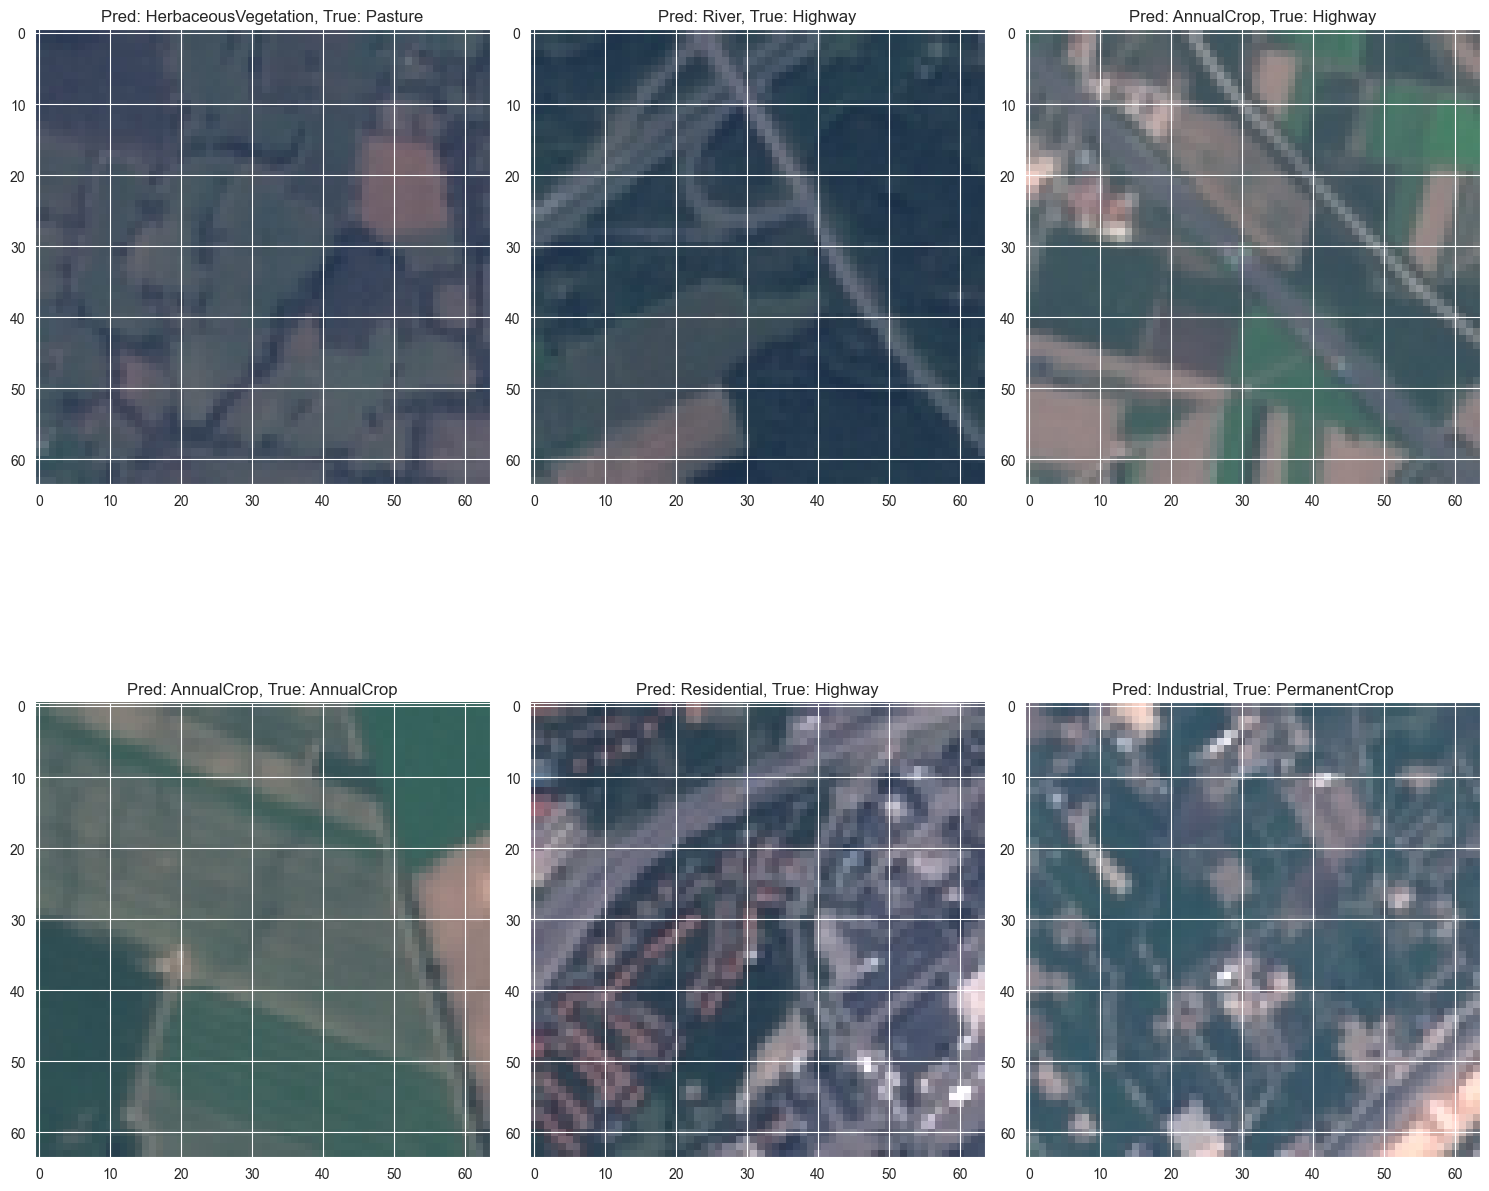

In [226]:
class_acc_preds_ensemble457 = {}
for i in range(len(rgb_lab_test_onehot[0])):
    class_acc_preds_ensemble457[i] = sum((preds_ensemble457[:,i] == rgb_lab_test_onehot[:,i]).astype(int))/len(rgb_lab_test_onehot[:,i])

for i, label in enumerate(unique_labels):
    indices = np.where(rgb_lab_test == label)[0]
    accuracy = np.mean(preds_ensemble457[indices] == rgb_lab_test_onehot[indices])
    print("Accuracy for class {}: {:.2f}%".format(label, accuracy * 100))

# based on the ensemble model, print out 5 random misclassified images
indices_preds_ensemble457 = np.where(preds_ensemble457 != rgb_lab_test_onehot)[0]
indices_preds_ensemble457 = np.random.choice(indices_preds_ensemble457, 6, replace=False)

fig, axs = plt.subplots(2, 3, figsize=(15, 15))

for i, idx in enumerate(indices_preds_ensemble457):
    row = i // 3
    col = i % 3
    label_pred = unique_labels[np.argmax(preds_ensemble457[idx])]
    label_true = unique_labels[np.argmax(rgb_lab_test_onehot[idx])]
    axs[row, col].imshow(rgb_img_test[idx])
    axs[row, col].set_title("Pred: {}, True: {}".format(label_pred, label_true))

plt.tight_layout()
plt.show()

### S7:

- Apply your best model on multispectral images. You may use whichever image channels you wish, so long as you use more than just RGB (although you are not required to use any color channels).

Q7.1: Calculate classification accuracy on the test data.

Q7.2: Compare against results using RGB images.

It took me a long time to get these loaded properly, but I managed it eventually. Because of how much memory the dataset takes up, I chose not to augment it. This will likely cost me accuracy but will allow me to run my models faster.

In [190]:
import os
import numpy as np
import matplotlib.pyplot as plt

ms_url = "C:/Users/Nissim/Desktop/Spring 2023/Remote Sensing/MUSA-650_Spring2023/Homeworks/ds/images/remote_sensing/otherDatasets/sentinel_2/tif"

from skimage import io

ms_images = []
ms_labels = []

for subfolder in os.listdir(ms_url):
    for image_filename in os.listdir(os.path.join(ms_url, subfolder)):
        image_path = os.path.join(ms_url, subfolder, image_filename)
        image = io.imread(image_path, plugin='tifffile')
        ms_images.append(image)
        ms_labels.append(subfolder)

ms_images = np.array(ms_images)
ms_labels = np.array(ms_labels)

In [191]:
ms_images.shape

(27000, 64, 64, 13)

In [194]:
# return the datatype of ms_images
print('ms_images is of type {}'.format(ms_images.dtype))

# convert to float32
ms_images = ms_images.astype('float32')

ms_images is of type uint16


In [195]:
# standardize pixel values to be between 0 and 1
ms_images = ms_images / ms_images.max()

Pixel values range from 0.0 to 109.81568908691406


In [197]:
# print the range of pixel values
print('Pixel values range from {} to {}'.format(ms_images.min(), ms_images.max()))

Pixel values range from 0.0 to 1.0


In [199]:
from sklearn.model_selection import train_test_split
ms_img_train, ms_img_test, ms_lab_train, ms_lab_test = train_test_split(ms_images, ms_labels, test_size=0.5, stratify=ms_labels)

# fit label encoder and transform labels
ms_lab_train_int = le.fit_transform(ms_lab_train)
ms_lab_test_int = le.transform(ms_lab_test)

# convert integer-encoded labels to one-hot encoded labels
ms_lab_train_onehot = to_categorical(ms_lab_train_int, num_classes)
ms_lab_test_onehot = to_categorical(ms_lab_test_int, num_classes)

In [200]:
ms_img_train.shape

(13500, 64, 64, 13)

In [201]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the model architecture
ms_model4 = Sequential()
ms_model4.add(Conv2D(32, (3, 3), activation='relu', input_shape=ms_img_train[0].shape))
ms_model4.add(MaxPooling2D((2, 2)))
ms_model4.add(Dropout(0.25))
ms_model4.add(Conv2D(64, (3, 3), activation='relu'))
ms_model4.add(MaxPooling2D((2, 2)))
ms_model4.add(Dropout(0.25))
ms_model4.add(Flatten())
ms_model4.add(Dense(128, activation='relu'))
ms_model4.add(Dropout(0.5))
ms_model4.add(Dense(num_classes, activation='softmax'))

# Compile the model
ms_model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
ms_history4 = ms_model4.fit(ms_img_train, ms_lab_train_onehot, batch_size=128, epochs=25, verbose=1, validation_split=0.1, shuffle = True)

# Evaluate the model on test data
ms_score4 = ms_model4.evaluate(ms_img_test, ms_lab_test_onehot, verbose=0)
print('Test loss:', ms_score4[0])
print('Test accuracy:', ms_score4[1])

Epoch 1/25
95/95 [==============================] - 20s 198ms/step - loss: 1.5903 - accuracy: 0.4243 - val_loss: 1.1042 - val_accuracy: 0.6156
Epoch 2/25
95/95 [==============================] - 18s 189ms/step - loss: 1.0672 - accuracy: 0.6244 - val_loss: 0.8033 - val_accuracy: 0.7289
Epoch 3/25
95/95 [==============================] - 17s 177ms/step - loss: 0.8921 - accuracy: 0.6867 - val_loss: 0.6841 - val_accuracy: 0.7630
Epoch 4/25
95/95 [==============================] - 17s 176ms/step - loss: 0.7815 - accuracy: 0.7259 - val_loss: 0.6186 - val_accuracy: 0.8081
Epoch 5/25
95/95 [==============================] - 17s 179ms/step - loss: 0.7195 - accuracy: 0.7525 - val_loss: 0.5343 - val_accuracy: 0.8156
Epoch 6/25
95/95 [==============================] - 17s 179ms/step - loss: 0.6444 - accuracy: 0.7739 - val_loss: 0.5987 - val_accuracy: 0.7904
Epoch 7/25
95/95 [==============================] - 19s 197ms/step - loss: 0.6426 - accuracy: 0.7813 - val_loss: 0.4879 - val_accuracy: 0.8430

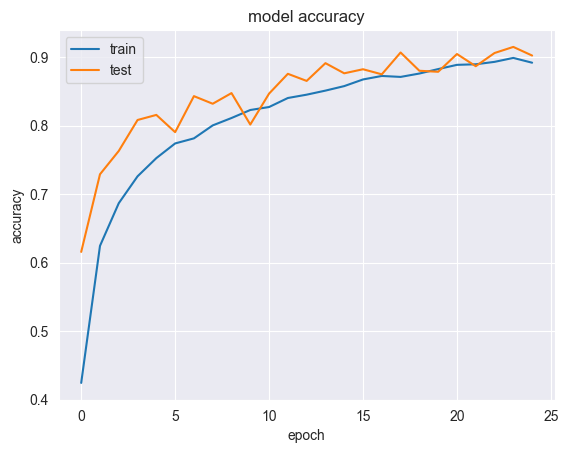

In [202]:
plt.plot(ms_history4.history['accuracy'])
plt.plot(ms_history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 13)]      0         
                                                                 
 conv2d_24 (Conv2D)          (None, 64, 64, 32)        3776      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 128)       7385

C:\Users\Nissim\Desktop\Spring 2023\Remote Sensing\MUSA-650_Spring2023\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


106/106 [==============================] - 26s 242ms/step - loss: 1.5673 - accuracy: 0.4217 - val_loss: 0.9943 - val_accuracy: 0.6510
Epoch 2/10
106/106 [==============================] - 25s 239ms/step - loss: 1.0318 - accuracy: 0.6283 - val_loss: 0.7995 - val_accuracy: 0.7271
Epoch 3/10
106/106 [==============================] - 25s 239ms/step - loss: 0.8478 - accuracy: 0.7064 - val_loss: 0.7585 - val_accuracy: 0.7362
Epoch 4/10
106/106 [==============================] - 25s 233ms/step - loss: 0.7023 - accuracy: 0.7582 - val_loss: 0.6288 - val_accuracy: 0.7741
Epoch 5/10
106/106 [==============================] - 25s 232ms/step - loss: 0.5942 - accuracy: 0.8038 - val_loss: 0.4033 - val_accuracy: 0.8690
Epoch 6/10
106/106 [==============================] - 24s 231ms/step - loss: 0.5326 - accuracy: 0.8247 - val_loss: 0.4088 - val_accuracy: 0.8580
Epoch 7/10
106/106 [==============================] - 26s 244ms/step - loss: 0.4790 - accuracy: 0.8436 - val_loss: 0.3848 - val_accuracy: 0.8

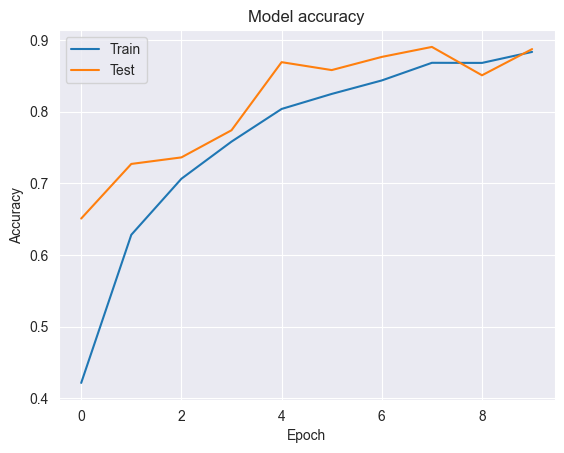

In [203]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam

# Define the MS-CNN architecture
ms_input_shape = (64, 64, 13)
inputs = Input(shape=ms_input_shape)

# Convolutional layer 1
x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Convolutional layer 2
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Convolutional layer 3
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the output and add fully connected layers
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

# Define the model
ms_model7 = Model(inputs=inputs, outputs=predictions)

# Compile the model
ms_model7.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary and plot the model graph
ms_model7.summary()

# Train the model
ms_history7 = ms_model7.fit(ms_img_train, ms_lab_train_onehot,
                            batch_size=128,
                            epochs=10,
                            verbose=1,
                            validation_data=(ms_img_test, ms_lab_test_onehot),
                            shuffle=True)

# Evaluate the model on test data
ms_score7 = ms_model7.evaluate(ms_img_test, ms_lab_test_onehot, verbose=0)
print('Validation loss:', ms_score7[0])
print('Validation accuracy:', ms_score7[1])

# Plot the training and validation accuracy
plt.plot(ms_history7.history['accuracy'])
plt.plot(ms_history7.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Both of these models in isolation are improvements over their previous RGB-only iterations. We'll now conclude by implementing an ensemble model that combines the two, which I anticipate will yield the best results.

In [229]:
# get predictions for models 4 and 7 on the multispectral test set
preds_ms_model4 = get_predictions([ms_model4], ms_img_test)
preds_ms_model7 = get_predictions([ms_model7], ms_img_test)

# combine predictions using averaging
preds_ensemble47_ms = np.concatenate((preds_ms_model4, preds_ms_model7), axis=0)
preds_ensemble47_ms = np.round(np.mean(preds_ensemble47_ms, axis=0))

# compute accuracy for multispectral ensemble model
accuracy_ms = np.mean(preds_ensemble47_ms == ms_lab_test_onehot)
print("Multispectral ensemble accuracy: {:.2f}%".format(accuracy_ms * 100))

# compute class accuracy for multispectral ensemble model
class_acc_preds_ensemble47_ms = {}
for i in range(len(ms_lab_test_onehot[0])):
    class_acc_preds_ensemble47_ms[i] = sum((preds_ensemble47_ms[:,i] == ms_lab_test_onehot[:,i]).astype(int))/len(ms_lab_test_onehot[:,i])

unique_labels_ms = np.unique(ms_lab_test)
for i, label in enumerate(unique_labels_ms):
    indices_ms = np.where(ms_lab_test == label)[0]
    accuracy_ms = np.mean(preds_ensemble47_ms[indices_ms] == ms_lab_test_onehot[indices_ms])
    print("Accuracy for class {}: {:.2f}%".format(label, accuracy_ms * 100))

422/422 [==============================] - 7s 16ms/step
Multispectral ensemble accuracy: 98.13%
Accuracy for class AnnualCrop: 97.81%
Accuracy for class Forest: 99.49%
Accuracy for class HerbaceousVegetation: 96.21%
Accuracy for class Highway: 95.94%
Accuracy for class Industrial: 98.69%
Accuracy for class Pasture: 98.20%
Accuracy for class PermanentCrop: 97.37%
Accuracy for class Residential: 98.22%
Accuracy for class River: 99.22%
Accuracy for class SeaLake: 99.96%


### Conclusions

Some takeaways from the work:

- Tweaking the parameters of the different models was interesting. As a general rule, training models longer increased accuracy even up to 100+ epochs. However, I did run into some issues with overfitting, and it also became prohibitively time-consuming to train for more epochs.
- Surprisingly, dropout actually decreased accuracy in some cases. I'm not sure why this is, but I think it may have to do with the small size of my dataset, as I mention above.
- Adding the pretrained model (I used VGG16) was helpful. It increased by model accuracy by about 7% over the next closest model, and I think it would have been even better had I been using my GPU and able to train it longer. Also, unfreezing and retraining parts of the base model might have made a difference.
- That being said, it seemed like ensemble models were the most effective. Assuming I implemented mine properly, my majority voting classifiers achieved higher accuracies than any other approach. This was especially interesting in my initial set of models (models 1-3), where the accuracy of the individual models was not very high. I think this is because the ensemble model was able to take advantage of the different strengths of the individual models, and it was able to correct for some of their weaknesses.

Challenges:
- This was the first homework in which computational time became prohibitive. The amount of time it took to train the models restricted how much I could play with the parameters, for instance, I didn't want to rerun them over and over. I had hoped to implement models with more layers and many more epochs of training, but this would have taken far too long. I also had hoped to implement a GAN as part of my data augmentation, but--again--this would have taken too long.
- I don't think I correctly implemented EarlyStopping, which means some of my models may have actually decreased their training accuracy over time. In a future homework, I would want to better tune parameters like early stopping and learning rate decay to see if I can improve my models. Again, though, this would require me to use my GPU and train for much longer.